In [1]:
!pip3 install torch torchvision

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torchvision import datasets, transforms

In [41]:
from torch.nn.modules.activation import Tanhshrink
transform = transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
training_dataset = datasets.MNIST(root='./data', train=True, download=True,transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True,transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)


In [29]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1,2,0)
  # print(image.shape)
  image = image * np.array((0.5,)) + np.array((0.5,))
  image = image.clip(0,1)
  return image

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


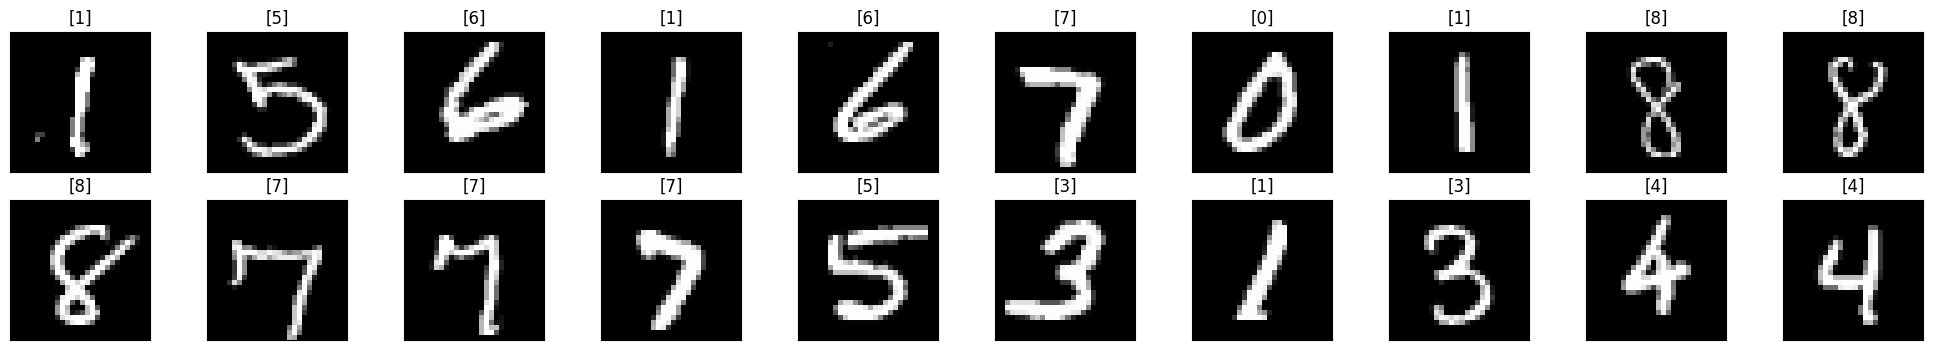

In [5]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[],yticks=[])
  plt.imshow(im_convert(images[idx]), cmap='gray')
  ax.set_title([labels[idx].item()])


In [6]:
class Classifier(nn.Module):

  def __init__(self, D_in, H1, H2, D_out):
    super().__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)

  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x

In [7]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [8]:
for p in model.parameters():
  if p.requires_grad:
    print(p.numel())
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

98000
125
8125
65
650
10
106975


In [9]:
# @title Cross Entropy Loss Example
# import torch
# import torch.nn as nn

# # Define some sample input data and labels.
# input_data = torch.Tensor([[0, 0.5, 1],[1,0.5,0]])  # 2 samples, 3 classes.
# weight = torch.Tensor([0,1,2])
# print(input_data)
# labels = torch.LongTensor([2, 1 ])  # target class indices.
# print(labels)
# # Create a criterion that measures the cross entropy loss.
# criterion = nn.CrossEntropyLoss(weight=weight)

# # Compute the loss.
# loss = criterion(input_data, labels)

# # Print the loss.
# print(loss)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [11]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for i in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _,preds = torch.max(outputs, 1)  # this gives indices of max elements
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels)

  epoch_loss = running_loss/len(training_loader)
  epoch_acc = running_corrects.float()/len(training_loader)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc)
  print(f"epoch {i+1}:")
  print('training loss:{:.4f}, training accuracy:{:.4f}'.format(epoch_loss, epoch_acc.item()))
  # Testing with Validation Dataset
  with torch.no_grad():
    for val_inputs, val_labels in validation_loader:
      val_inputs = val_inputs.view(val_inputs.shape[0], -1)
      val_outputs = model.forward(val_inputs)
      val_loss = criterion(val_outputs, val_labels)

      _,val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels)
  val_epoch_loss = val_running_loss/len(validation_loader)
  val_epoch_acc = val_running_corrects.float()/len(validation_loader)
  val_running_loss_history.append(val_epoch_loss)
  val_running_corrects_history.append(val_epoch_acc)
  print('Validation loss:{:.4f}, Validation Accuracy:{:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))
  print("\n")




epoch 1:
training loss:0.9504, training accuracy:76.9867
Validation loss:0.4275, Validation Accuracy:89.1200


epoch 2:
training loss:0.3833, training accuracy:89.2417
Validation loss:0.3283, Validation Accuracy:90.8200


epoch 3:
training loss:0.3215, training accuracy:90.8317
Validation loss:0.2901, Validation Accuracy:91.8400


epoch 4:
training loss:0.2886, training accuracy:91.7350
Validation loss:0.2654, Validation Accuracy:92.3100


epoch 5:
training loss:0.2641, training accuracy:92.3750
Validation loss:0.2462, Validation Accuracy:92.9200


epoch 6:
training loss:0.2436, training accuracy:92.9583
Validation loss:0.2292, Validation Accuracy:93.1900


epoch 7:
training loss:0.2249, training accuracy:93.4883
Validation loss:0.2124, Validation Accuracy:93.7600


epoch 8:
training loss:0.2092, training accuracy:94.0100
Validation loss:0.1967, Validation Accuracy:94.3000


epoch 9:
training loss:0.1939, training accuracy:94.4717
Validation loss:0.1854, Validation Accuracy:94.6600


e

Text(0.5, 1.0, 'Loss')

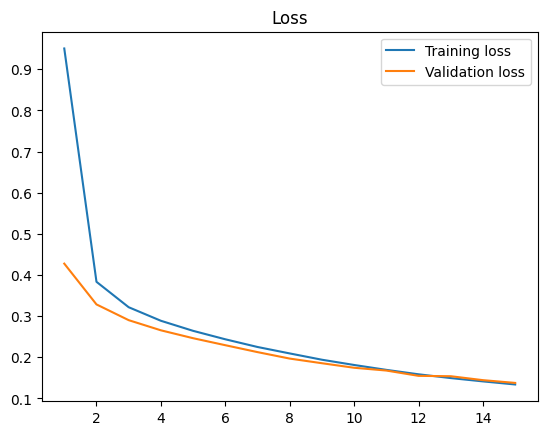

In [12]:
plt.plot(range(1,epochs+1),running_loss_history,label='Training loss')
plt.plot(range(1,epochs+1),val_running_loss_history, label="Validation loss")
plt.legend()
plt.title("Loss")

Text(0.5, 1.0, 'Accuracy')

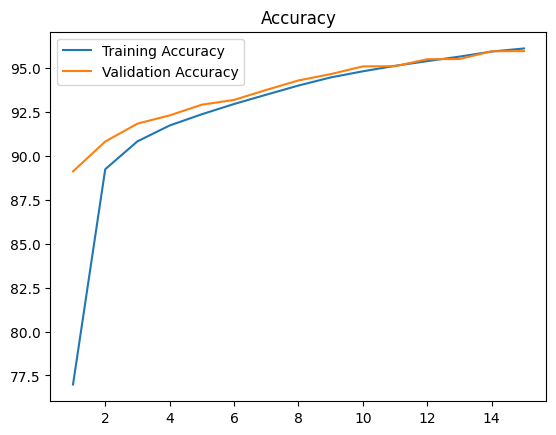

In [13]:
plt.plot(range(1,epochs+1),running_corrects_history,label='Training Accuracy')
plt.plot(range(1,epochs+1),val_running_corrects_history,label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

Text(0.5, 1.0, 'Error')

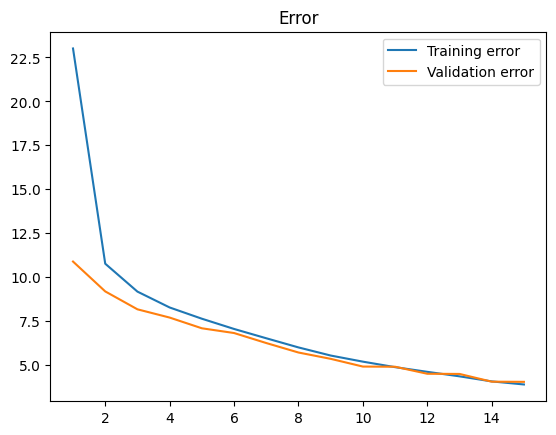

In [14]:
plt.plot(range(1,epochs+1),100-np.array(running_corrects_history),label='Training error')
plt.plot(range(1,epochs+1),100-np.array(val_running_corrects_history),label='Validation error')
plt.legend()
plt.title("Error")

**Testing with new image from internet**

--2023-10-26 14:25:55--  https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg
Resolving images.homedepot-static.com (images.homedepot-static.com)... 35.186.226.36
Connecting to images.homedepot-static.com (images.homedepot-static.com)|35.186.226.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21010 (21K) [image/jpeg]
Saving to: ‘downloaded_image.jpg’

downloaded_image.jp 100%[===================>]  20.52K  --.-KB/s    in 0.05s   

2023-10-26 14:25:55 (374 KB/s) - ‘downloaded_image.jpg’ saved [21010/21010]



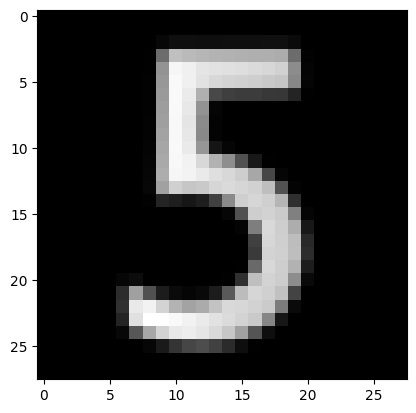

In [43]:
!wget 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg' -O downloaded_image.jpg
import cv2 as cv
from PIL import Image
img = cv.imread('downloaded_image.jpg')
grey_img = cv.cvtColor(img,cv.COLOR_BGR2GRAY) # converting to gray scale
img = cv.bitwise_not(grey_img) # invert the img,change white background to black
# print(type(img))
img1 = Image.fromarray(img)
img1 = transform(img1)
# print(type(img1))
# print(img1.shape)
plt.imshow(im_convert(img1),cmap='gray')


In [44]:
img1 = img1.view(img1.shape[0],-1)
# print(img1.shape)
pred = model.forward(img1)
_,pred_label = torch.max(pred, 1)
print(pred_label.item())


5


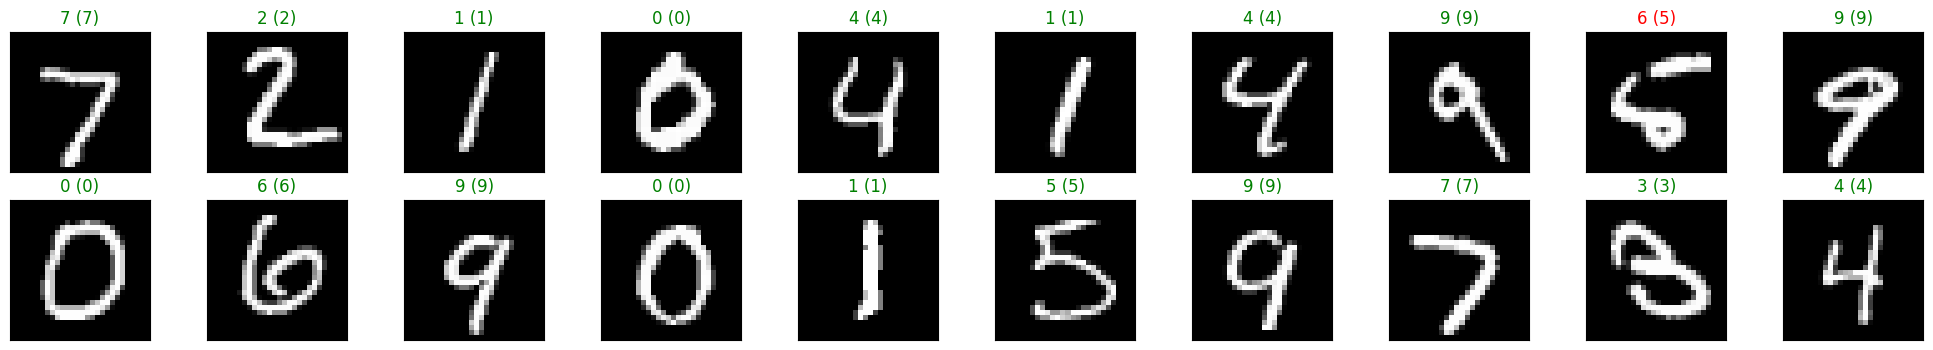

In [46]:
# Testing on set of valiadation images
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output,1)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[],yticks=[])
  plt.imshow(im_convert(images[idx]), cmap='gray')
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))